In [1]:
!pip install -q scikit-learn imbalanced-learn xgboost pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_STATE = 42


In [4]:
df = pd.read_csv('/content/Updated_Wine_Dataset.csv')  #/content/Updated_Wine_Dataset.csv
print("Raw data shape:", df.shape)
print("Missing values:\n", df.isna().sum())
print("\nNumber of duplicate rows:", df.duplicated().sum())


df['free_total_sulf_ratio'] = df['free sulfur dioxide'] / (df['total sulfur dioxide'] + 1)

skewed = ['residual sugar','chlorides','sulphates',
          'total sulfur dioxide','free sulfur dioxide']
for col in skewed:
    df[col] = np.log1p(df[col])




Raw data shape: (4898, 13)
Missing values:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine color              0
dtype: int64

Number of duplicate rows: 937


In [5]:
df = df.drop_duplicates().reset_index(drop=True)
print("Cleaned data shape:", df.shape)


Cleaned data shape: (3961, 14)


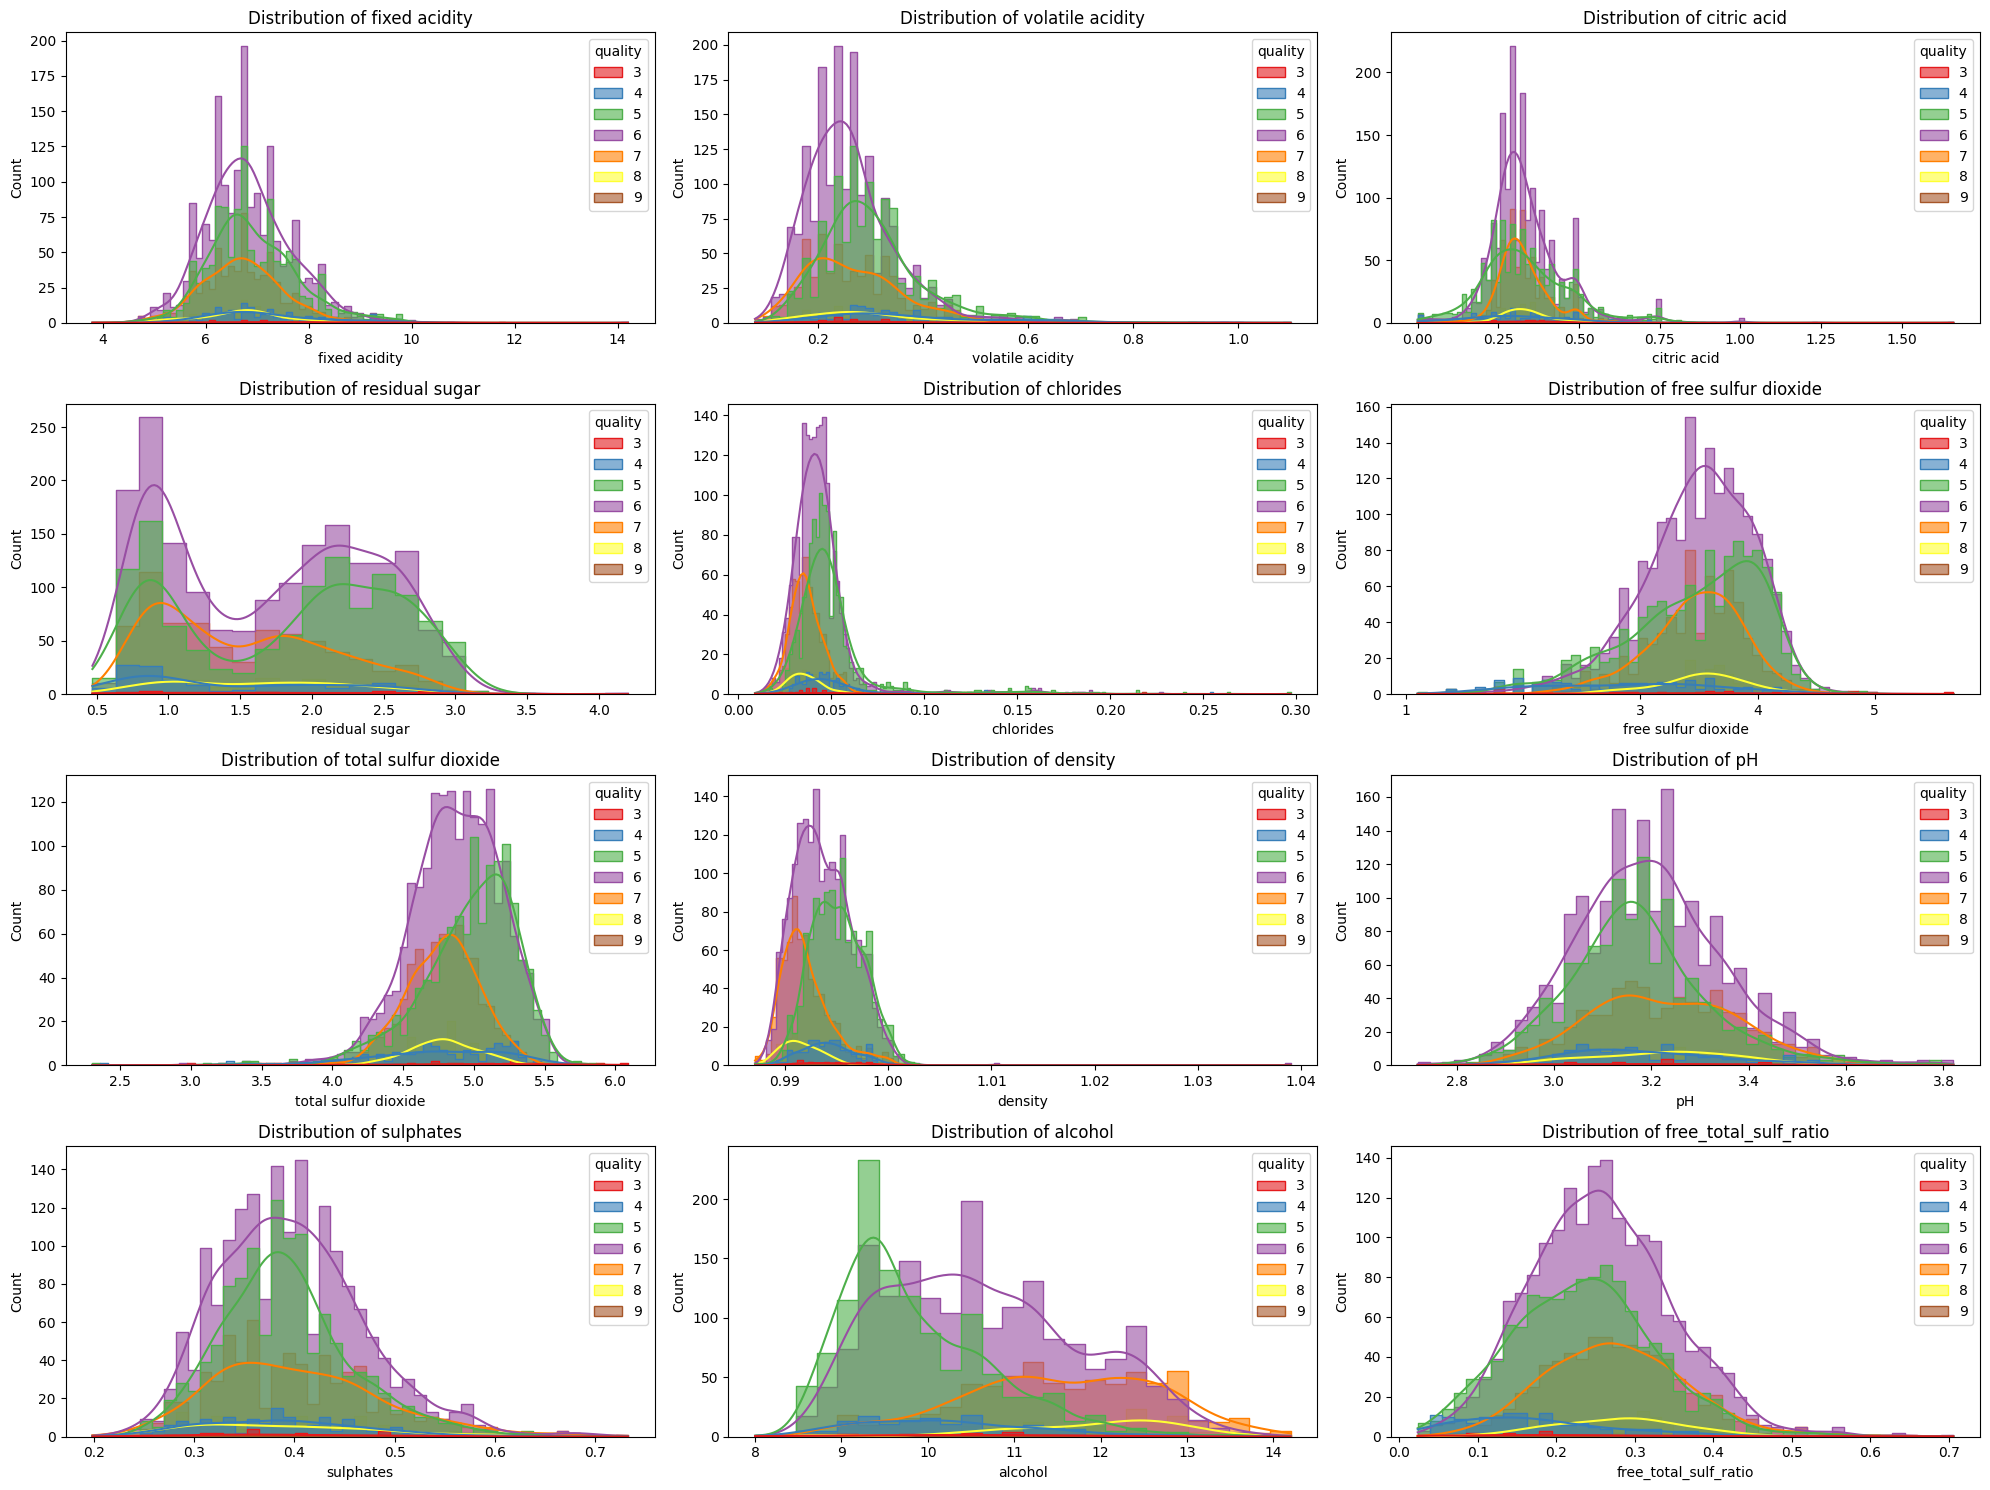

In [6]:
df['target'] = (df['quality'] >= 7).astype(int)
df['target'].value_counts()

fig, axs = plt.subplots(4, 3, figsize=(20, 15))
axs = axs.flatten()

palette = sns.color_palette('Set1', n_colors=df['quality'].nunique())

for i, col in enumerate(df.drop(['quality', 'target', 'wine color'], axis=1).columns[:12]):
    sns.histplot(
        data=df, x=col, hue='quality', ax=axs[i],
        kde=True, element="step", palette=palette, alpha=0.6
    )
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [7]:
df['log_sugar']  = np.log1p(df['residual sugar'])
df['log_sulfur'] = np.log1p(df['total sulfur dioxide'])

X = df.drop(['quality', 'target'], axis=1)
y = df['target']


numeric_features   = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['wine color']


In [8]:
X = df.drop(['quality', 'target'], axis=1)
y = df['target']

from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.20, stratify=y_temp, random_state=RANDOM_STATE)

print('train', X_train.shape, 'val', X_val.shape, 'test', X_test.shape)

train (2534, 15) val (634, 15) test (793, 15)


In [9]:
numeric_features.append('log_sugar')
numeric_features.append('log_sulfur')
X = df.drop(['quality', 'target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)

print("Training distribution:\n", y_train.value_counts(normalize=True))
print("\nTest distribution:\n", y_test.value_counts(normalize=True))


Training distribution:
 target
0    0.791667
1    0.208333
Name: proportion, dtype: float64

Test distribution:
 target
0    0.791929
1    0.208071
Name: proportion, dtype: float64


In [10]:
display(df.isna().sum())
display(df.describe())


,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,free_total_sulf_ratio,target,log_sugar,log_sulfur
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000
mean,6.839346,0.280538,0.334332,1.688150,0.044655,3.456563,4.875965,0.993790,3.195458,0.396216,10.589358,5.854835,0.252508,0.208281,0.952618,1.769132
std,0.866860,0.103437,0.122446,0.710091,0.021012,0.529867,0.338556,0.002905,0.151546,0.074166,1.217076,0.890683,0.094122,0.406130,0.271987,0.059761
min,3.800000,0.080000,0.000000,0.470004,0.008960,1.098612,2.302585,0.987110,2.720000,0.198851,8.000000,3.000000,0.023438,0.000000,0.385265,1.194706
25%,6.300000,0.210000,0.270000,0.955511,0.034401,3.178054,4.672829,0.991620,3.090000,0.343590,9.500000,5.000000,0.187050,0.000000,0.670652,1.735688
50%,6.800000,0.260000,0.320000,1.740466,0.041142,3.526361,4.897840,0.993500,3.180000,0.392042,10.400000,6.000000,0.250000,0.000000,1.008128,1.774586
75%,7.300000,0.330000,0.390000,2.292535,0.048790,3.828641,5.117994,0.995710,3.290000,0.438255,11.400000,6.000000,0.312000,0.000000,1.191658,1.811234
max,14.200000,1.100000,1.660000,4.201703,0.297137,5.669881,6.089045,1.038980,3.820000,0.732368,14.200000,9.000000,0.705882,1.000000,1.648986,1.958551


In [11]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(3168, 15) (793, 15) (3168,) (793,)


In [12]:
numeric_features   = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['wine color']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [13]:
RANDOM_STATE = 42
POS_WEIGHT   = 3.8   # ≈ neg / pos

models = {

    'LogReg': LogisticRegression(
        solver='liblinear', C=1.0, class_weight='balanced',
        max_iter=1000, random_state=RANDOM_STATE),


    'RandomForest': RandomForestClassifier(
        n_estimators=500, min_samples_split=4, min_samples_leaf=2,
        class_weight='balanced_subsample', n_jobs=-1, random_state=RANDOM_STATE),


    'GradBoost': GradientBoostingClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=3,
        subsample=0.8, random_state=RANDOM_STATE),


    'XGBoost': XGBClassifier(
        n_estimators=600, learning_rate=0.03, max_depth=4,
        subsample=0.8, colsample_bytree=0.8,
        scale_pos_weight=POS_WEIGHT,
        objective='binary:logistic', eval_metric='logloss',
        n_jobs=-1, random_state=RANDOM_STATE),

    # — SVM —
    'SVC': SVC(
        kernel='rbf', C=5, gamma='scale',
        probability=True, class_weight='balanced',
        random_state=RANDOM_STATE),


    'KNN1': KNeighborsClassifier(
        n_neighbors=5,   weights='uniform',  p=2),
    'KNN2': KNeighborsClassifier(
        n_neighbors=10,  weights='distance', p=2),
    'KNN3': KNeighborsClassifier(
        n_neighbors=21,  weights='distance', p=2)
}


,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
RandomForest,0.806,0.019,0.532,0.040,0.617,0.021,0.571,0.029,0.841,0.020
LogReg,0.744,0.021,0.437,0.027,0.783,0.045,0.561,0.029,0.822,0.016
XGBoost,0.732,0.020,0.424,0.022,0.792,0.042,0.552,0.024,0.830,0.018
SVC,0.762,0.009,0.453,0.013,0.676,0.033,0.542,0.016,0.812,0.013
KNN2,0.716,0.011,0.407,0.009,0.788,0.026,0.536,0.010,0.818,0.021
GradBoost,0.795,0.019,0.508,0.040,0.564,0.053,0.534,0.043,0.827,0.021
KNN3,0.686,0.019,0.383,0.015,0.832,0.027,0.525,0.016,0.823,0.014
KNN1,0.713,0.013,0.400,0.014,0.750,0.035,0.521,0.019,0.788,0.026


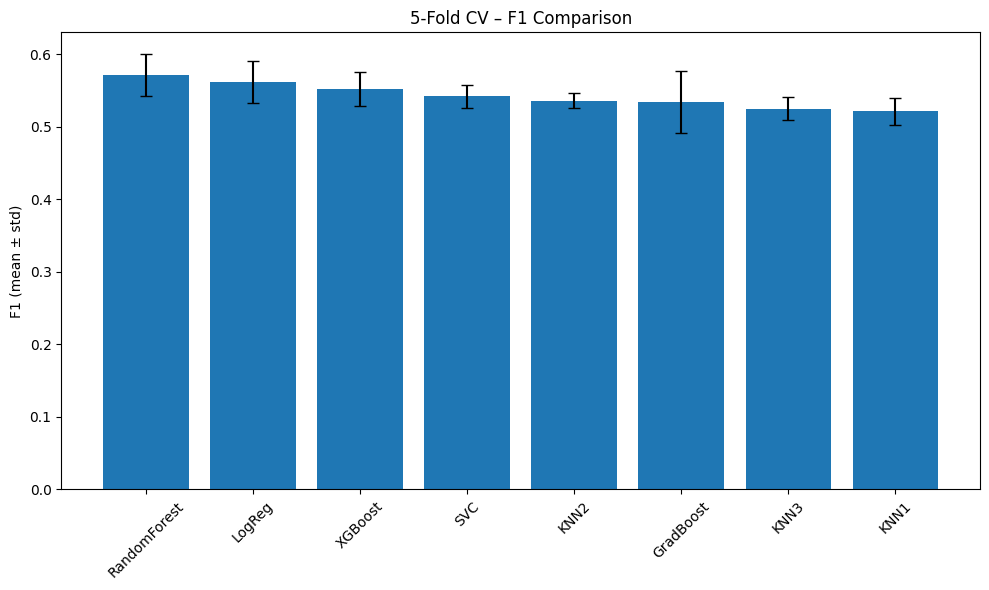

In [14]:
cv_results = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for name, clf in models.items():
    pipe = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('model', clf)
    ])
    scores = cross_validate(
        pipe, X_train, y_train, cv=cv,
        scoring=scoring, n_jobs=-1, return_train_score=False
    )

    # store mean + std
    cv_results[name] = {f'{m}_mean': scores[f'test_{m}'].mean()
                        for m in scoring} | {
                        f'{m}_std' : scores[f'test_{m}'].std()
                        for m in scoring}

# Convert to DataFrame, sort by F1 mean
cols = sum([[f'{m}_mean', f'{m}_std'] for m in scoring], [])
results_df = (
    pd.DataFrame(cv_results).T[cols]
      .sort_values(by='f1_mean', ascending=False)
      .round(3)
)
display(results_df)



plt.figure(figsize=(10, 6))
plt.bar(
      x=results_df.index,
    height=results_df['f1_mean'],
    yerr=results_df['f1_std'],
    capsize=4
)
plt.ylabel('F1 (mean ± std)'); plt.title('5-Fold CV – F1 Comparison')
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

In [15]:
param_grid = {
    'model__n_estimators'     : [300, 500, 800],
    'model__max_depth'        : [None, 10, 20],
    'model__min_samples_split': [2, 4, 6],
    'model__min_samples_leaf' : [1, 2, 4],
    'model__max_features'     : ['sqrt', 'log2'],
}

pipe = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('model', models['RandomForest'])
])

grid = GridSearchCV(
    pipe, param_grid, cv=cv,
    scoring='f1', n_jobs=-1, verbose=2
)

grid.fit(X_train, y_train)

print("Best Hyper-Param:", grid.best_params_)
print("Best CV F1:", grid.best_score_.round(3))
best_model = grid.best_estimator_


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyper-Param: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 800}
Best CV F1: 0.575


Accuracy : 0.8234552332912989
Precision: 0.5647668393782384
Recall   : 0.6606060606060606
F1-Score : 0.6089385474860335
ROC-AUC  : 0.8555201698513801

Classification Report
               precision    recall  f1-score   support

           0       0.91      0.87      0.89       628
           1       0.56      0.66      0.61       165

    accuracy                           0.82       793
   macro avg       0.74      0.76      0.75       793
weighted avg       0.84      0.82      0.83       793



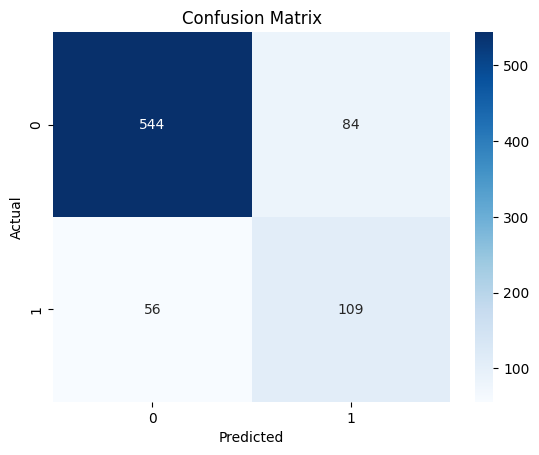

In [16]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-Score :", f1_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba))

print("\nClassification Report\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

In [17]:

import joblib
joblib.dump(best_model, 'white_wine_quality_model.pkl')


['white_wine_quality_model.pkl']

In [ ]:
          
import shap
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
shap.initjs()


In [ ]:

feature_names = best_model.named_steps["preprocess"].get_feature_names_out()

rng = np.random.default_rng(42)
background_idx  = rng.choice(len(X_train), size=min(100, len(X_train)), replace=False)
background_data = best_model.named_steps["preprocess"].transform(X_train.iloc[background_idx])

explainer = shap.Explainer(
    best_model.named_steps["model"],
    background_data,
    feature_names=feature_names
)

X_test_trans = best_model.named_steps["preprocess"].transform(X_test)


100%|===================| 1585/1586 [07:28<00:00]       

<Figure size 640x480 with 0 Axes>

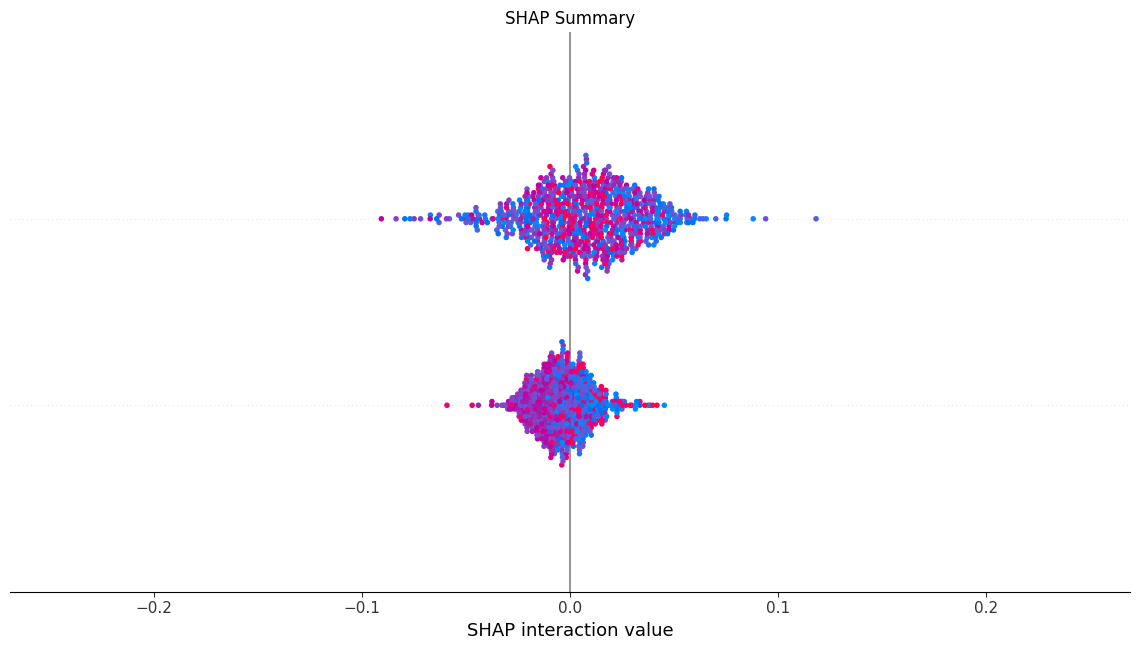

In [ ]:
##  Global SHAP 
shap_vals = explainer(X_test_trans, check_additivity=False)
shap.summary_plot(shap_vals, X_test_trans, feature_names=feature_names,
                  show=False); plt.title("SHAP Summary"); plt.tight_layout(); plt.show()


,feature,mean,std
0,num__alcohol,0.228123,0.027281
1,num__density,0.076692,0.020077
2,num__chlorides,0.051924,0.019172
3,num__free_total_sulf_ratio,0.028734,0.014400
4,num__pH,0.023374,0.008386
5,num__citric acid,0.020038,0.014132
6,num__volatile acidity,0.015135,0.007600
7,num__free sulfur dioxide,0.012477,0.013131
8,num__total sulfur dioxide,0.010258,0.010769
9,num__log_sulfur,0.009210,0.010279


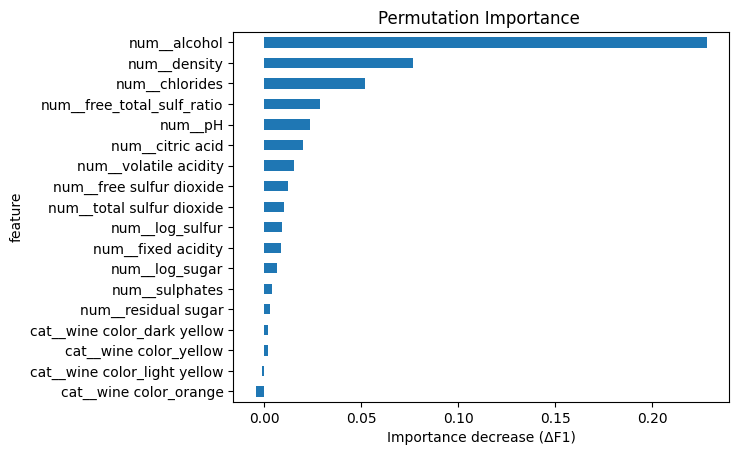

In [ ]:
##  Permutation Importance


estimator = best_model.named_steps["model"]


perm = permutation_importance(
    estimator,
    X_test_trans,            
    y_test.values,          
    n_repeats=25,
    random_state=42,
    scoring="f1",
    n_jobs=-1
)


perm_df = (pd.DataFrame({
        "feature": feature_names,
        "mean":    perm.importances_mean,
        "std":     perm.importances_std
    })
    .sort_values("mean", ascending=False)
    .reset_index(drop=True)
)

display(perm_df.head(12))

# Grafik
perm_df.set_index("feature")["mean"].plot(kind="barh")

plt.gca().invert_yaxis()
plt.xlabel("Importance decrease (ΔF1)")
plt.title("Permutation Importance ")
plt.show()


In [32]:
import re

perm_df_full = (pd.DataFrame({
        "feature": feature_names,
        "mean":    perm.importances_mean,
        "std":     perm.importances_std
    })
    .sort_values("mean", ascending=False)
    .reset_index(drop=True)
)


perm_df_full["clean_name"] = perm_df_full["feature"].str.replace(r"^(num|cat)__", "", regex=True)


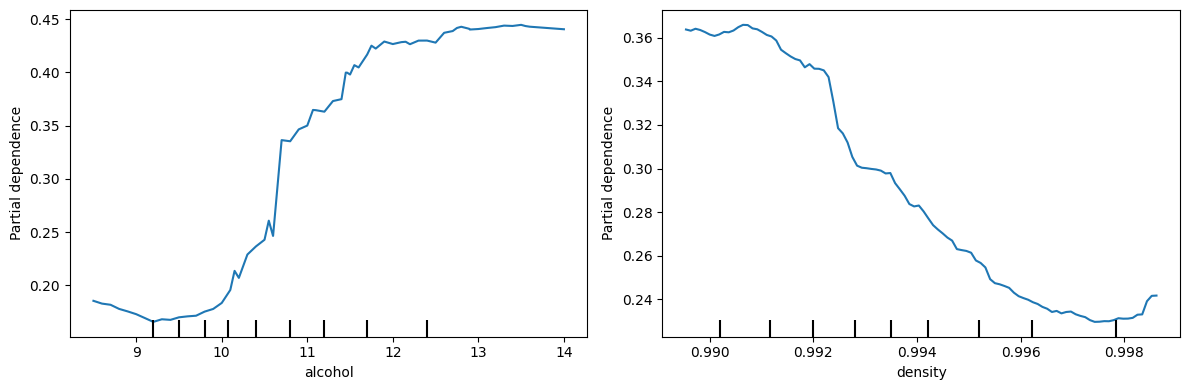

In [33]:
##  PDP


top2 = perm_df_full.head(2)["clean_name"].tolist()

fig, ax = plt.subplots(1, len(top2), figsize=(6*len(top2), 4), sharey=False)
for i, feat in enumerate(top2):
    PartialDependenceDisplay.from_estimator(
        best_model,
        X_test,
        [feat],
        ax=ax[i] if len(top2) > 1 else ax,
        kind="average"
    )
plt.tight_layout(); plt.show()


,feature,mean,std
0,num__alcohol,0.228123,0.027281
1,num__density,0.076692,0.020077
2,num__chlorides,0.051924,0.019172
3,num__free_total_sulf_ratio,0.028734,0.014400
4,num__pH,0.023374,0.008386
5,num__citric acid,0.020038,0.014132
6,num__volatile acidity,0.015135,0.007600
7,num__free sulfur dioxide,0.012477,0.013131
8,num__total sulfur dioxide,0.010258,0.010769
9,num__log_sulfur,0.009210,0.010279


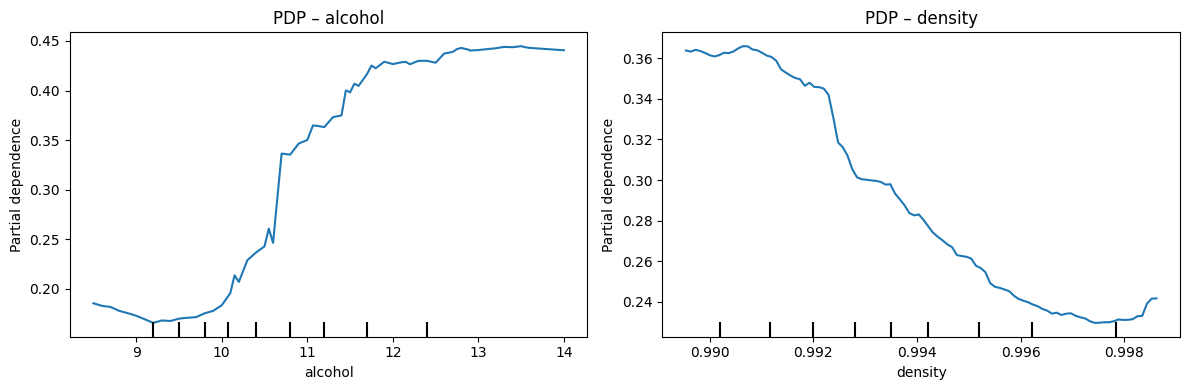

In [ ]:
## PDP 

import re


perm_num = perm_df[perm_df["feature"].str.startswith("num__")].copy()
perm_num = perm_num.sort_values("mean", ascending=False).reset_index(drop=True)


display(perm_num.head(len(perm_num)))


top2_prefixed = perm_num.head(2)["feature"].tolist()         
top2 = [re.sub(r"^num__", "", f) for f in top2_prefixed]     

# 3) PDP çiz
fig, ax = plt.subplots(1, len(top2), figsize=(6 * len(top2), 4), sharey=False)
for i, feat in enumerate(top2):
    PartialDependenceDisplay.from_estimator(
        best_model,              # Pipeline
        X_test,                  
        [feat],                  
        ax=ax[i] if len(top2) > 1 else ax,
        kind="average"
    )
    ax[i].set_title(f"PDP – {feat}")
plt.tight_layout(); plt.show()


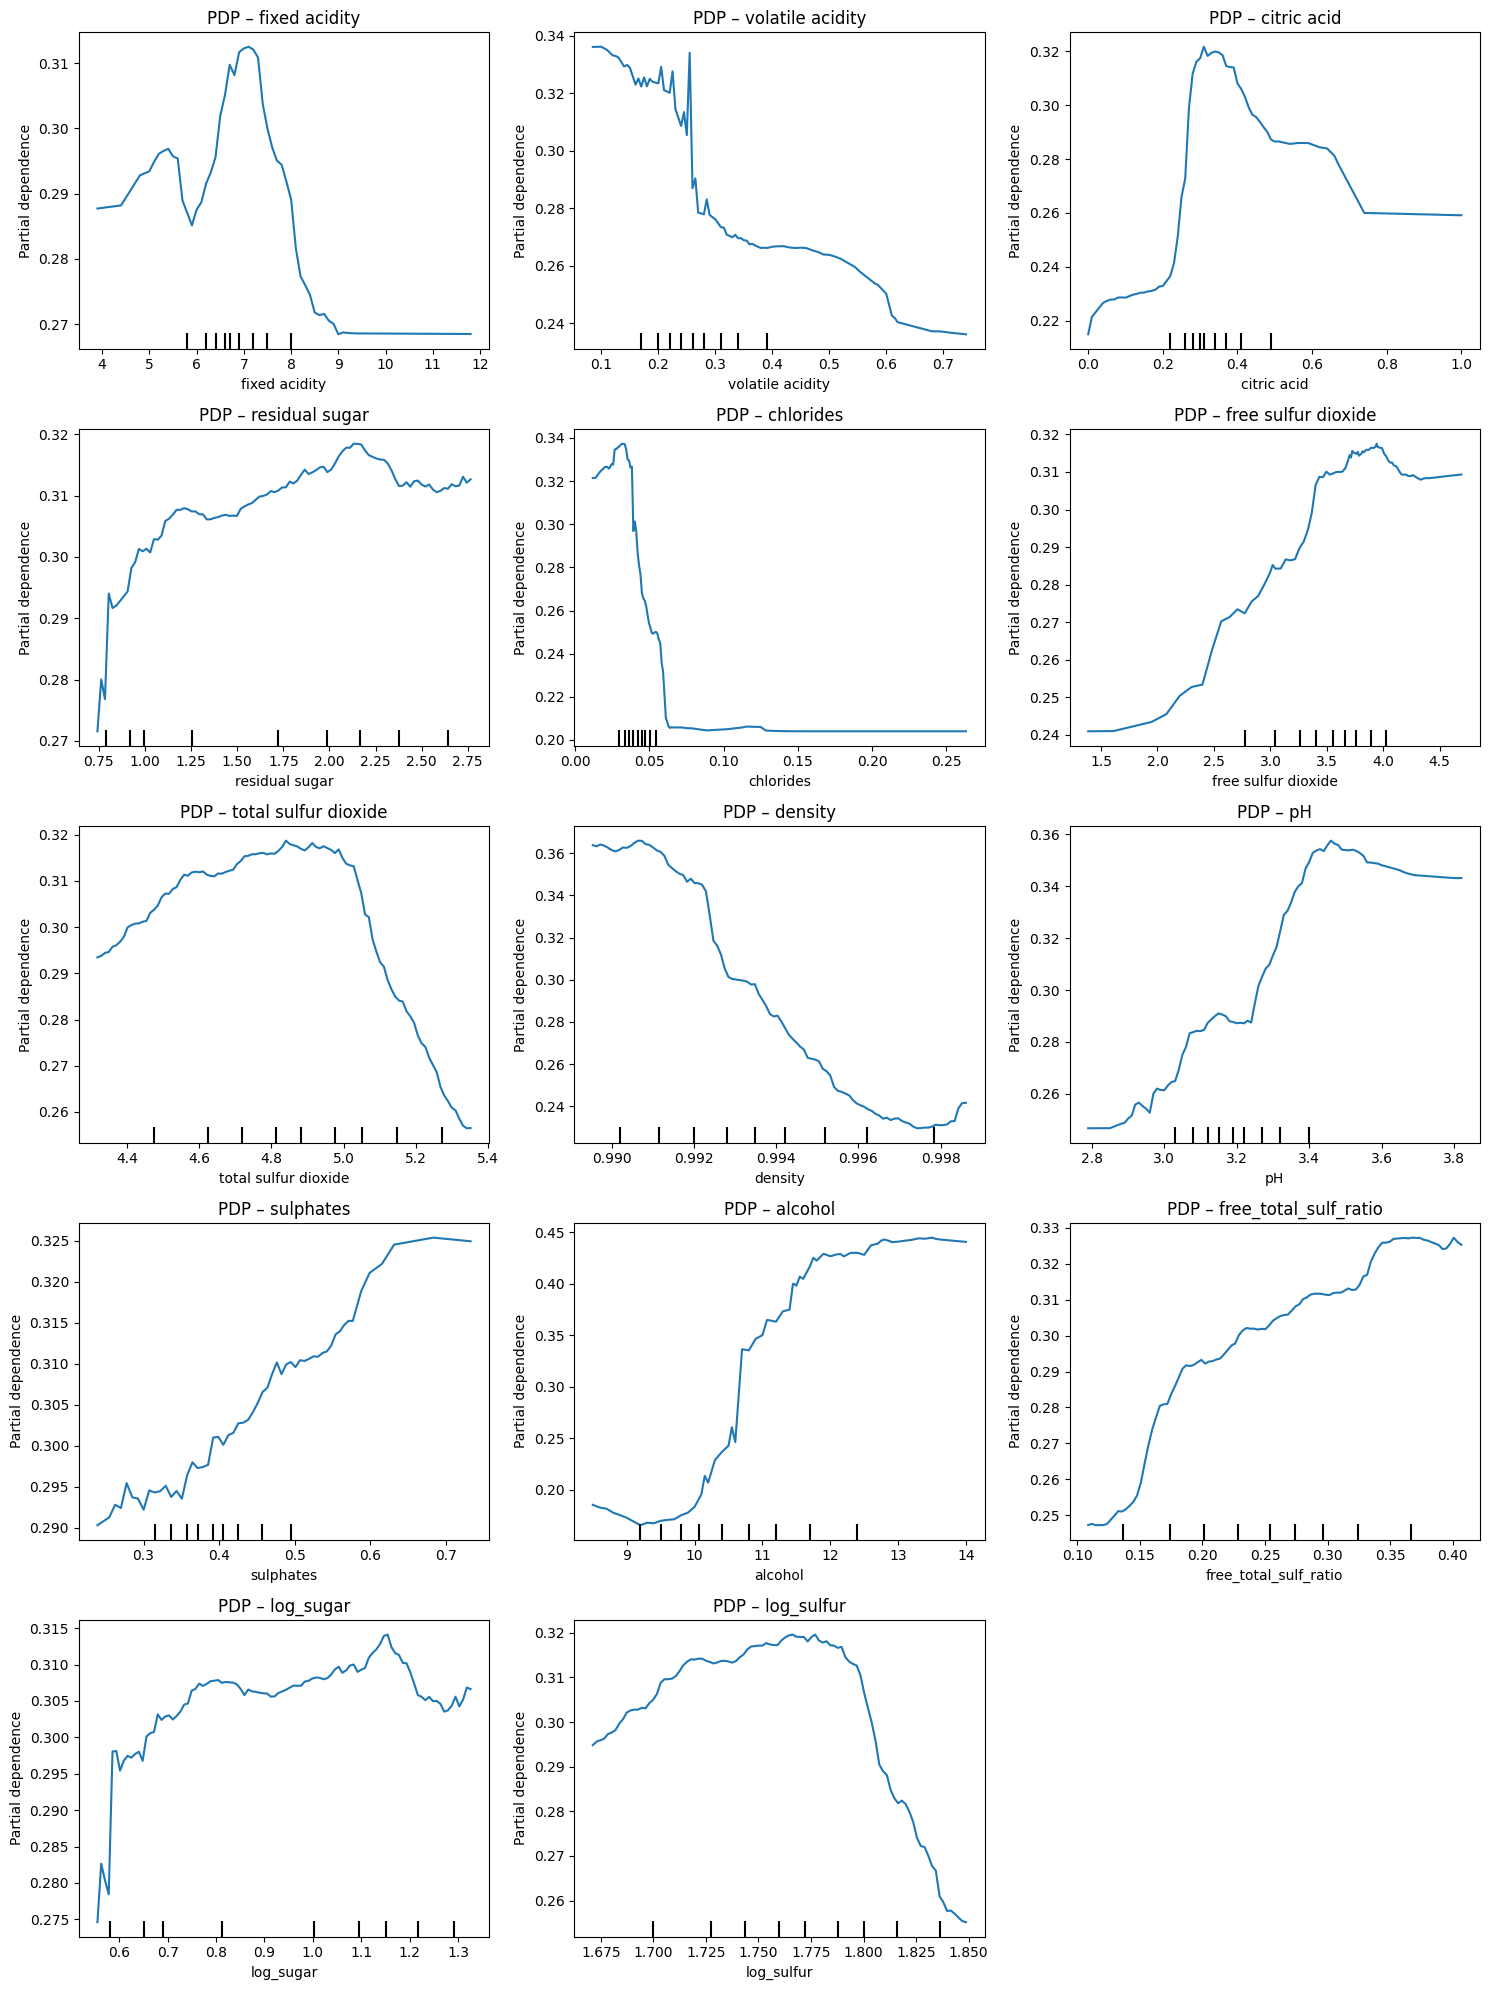

In [ ]:
## PDP 

import re
from math import ceil
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt


numeric_prefixed = [f for f in feature_names if f.startswith("num__")]


numeric_clean = [re.sub(r"^num__", "", f) for f in numeric_prefixed]


n_feats  = len(numeric_clean)
n_cols   = 3                              
n_rows   = ceil(n_feats / n_cols)

fig, ax = plt.subplots(
    n_rows, n_cols,
    figsize=(5 * n_cols, 4 * n_rows),
    sharey=False
)
ax = ax.flatten()                        


for i, feat in enumerate(numeric_clean):
    PartialDependenceDisplay.from_estimator(
        best_model,                      
        X_test,                          
        [feat],
        ax=ax[i],
        kind="average"
    )
    ax[i].set_title(f"PDP – {feat}")


for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()


BİLGİLENDİRİCİ Doğru Tahminler:


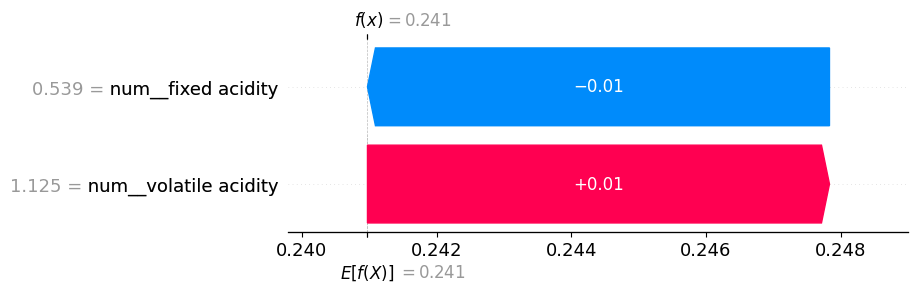

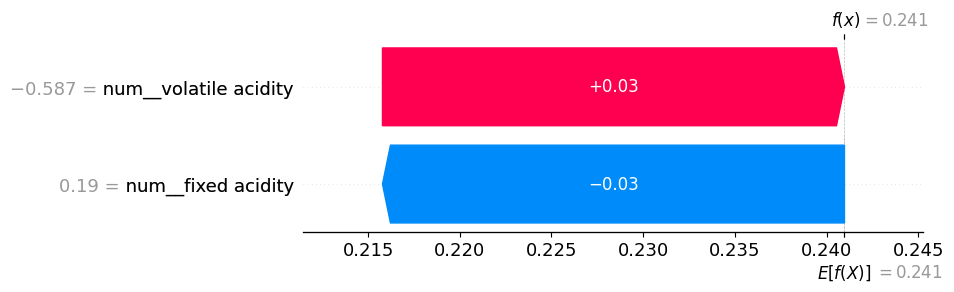

BİLGİLENDİRİCİ Yanlış Tahminler:


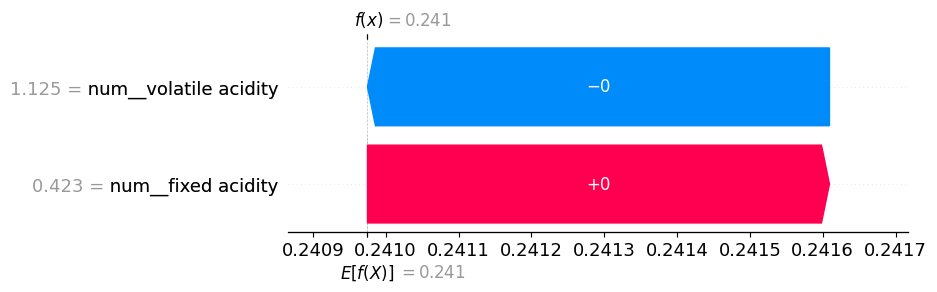

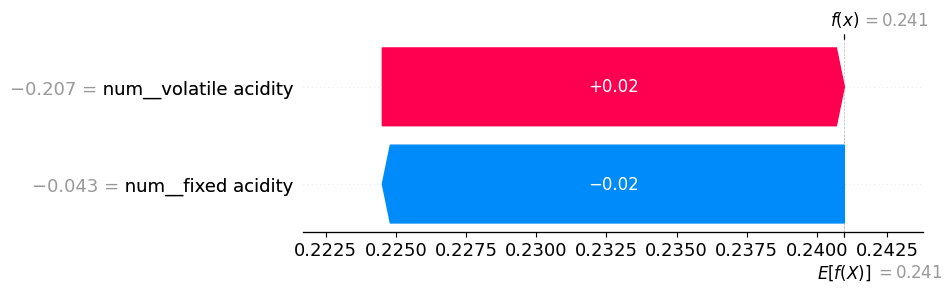

In [ ]:


import numpy as np
import shap

def make_single_output_expl(shap_vals, sample_idx, class_idx=1, feature_names=None):
    """ Çok-çıktılı Explanation → tek-çıktılı (skalar base) """
    vals = shap_vals.values[sample_idx, class_idx, :]           
    
    if shap_vals.base_values.ndim == 2:                         
        base = shap_vals.base_values[sample_idx, class_idx]
    else:                                                       
        base = shap_vals.base_values[class_idx]
    data = shap_vals.data[sample_idx, :]
    return shap.Explanation(values=vals, base_values=base,
                            data=data, feature_names=feature_names)


f_x = best_model.predict_proba(X_test)[:, 1]                    

if shap_vals.base_values.ndim == 2:                             
    base_vec = shap_vals.base_values[:, 1]
else:                                                           
    base_vec = np.full_like(f_x, shap_vals.base_values[1])

deviation = np.abs(f_x - base_vec)

correct_idx = np.where(y_pred == y_test)[0]
wrong_idx   = np.where(y_pred != y_test)[0]

top_corr  = correct_idx[np.argsort(deviation[correct_idx])[-2:]]
top_wrong = wrong_idx[np.argsort(deviation[wrong_idx])[-2:]]


print(" Doğru Tahminler:")
for i in top_corr:
    expl = make_single_output_expl(shap_vals, i, class_idx=1, feature_names=feature_names)
    shap.plots.waterfall(expl, max_display=10)

print("Yanlış Tahminler:")
for i in top_wrong:
    expl = make_single_output_expl(shap_vals, i, class_idx=1, feature_names=feature_names)
    shap.plots.waterfall(expl, max_display=10)



### DOĞRU-POZİTİF (yüksek sapma) – index 26 (Gerçek=0; Tahmin=0)


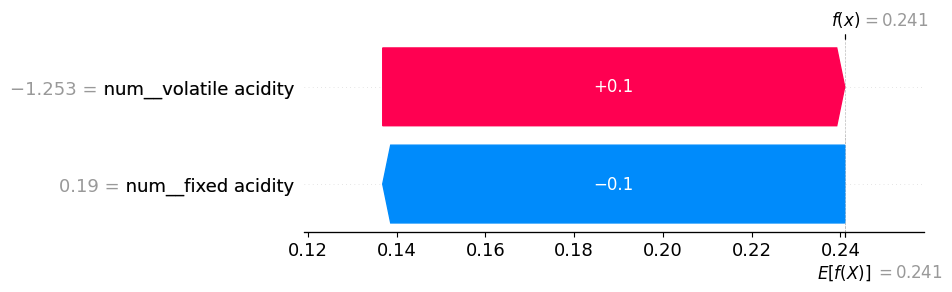

In [45]:
# Farkı en büyük pozitif tahmin örneği
delta = np.abs(shap_vals.values[:, 1, :]).sum(axis=1)
idx_big = delta.argmax()

expl  = single_output_expl(shap_vals, idx_big, class_idx=1, feature_names=feature_names)
print(f"\n### DOĞRU-POZİTİF (yüksek sapma) – index {idx_big} "
      f"(Gerçek={y_test.iloc[idx_big]}; Tahmin={y_pred[idx_big]})")
shap.plots.waterfall(expl, max_display=10)


Text(0.5, 1.0, 'Class 0 – SHAP')

<Figure size 1000x400 with 0 Axes>

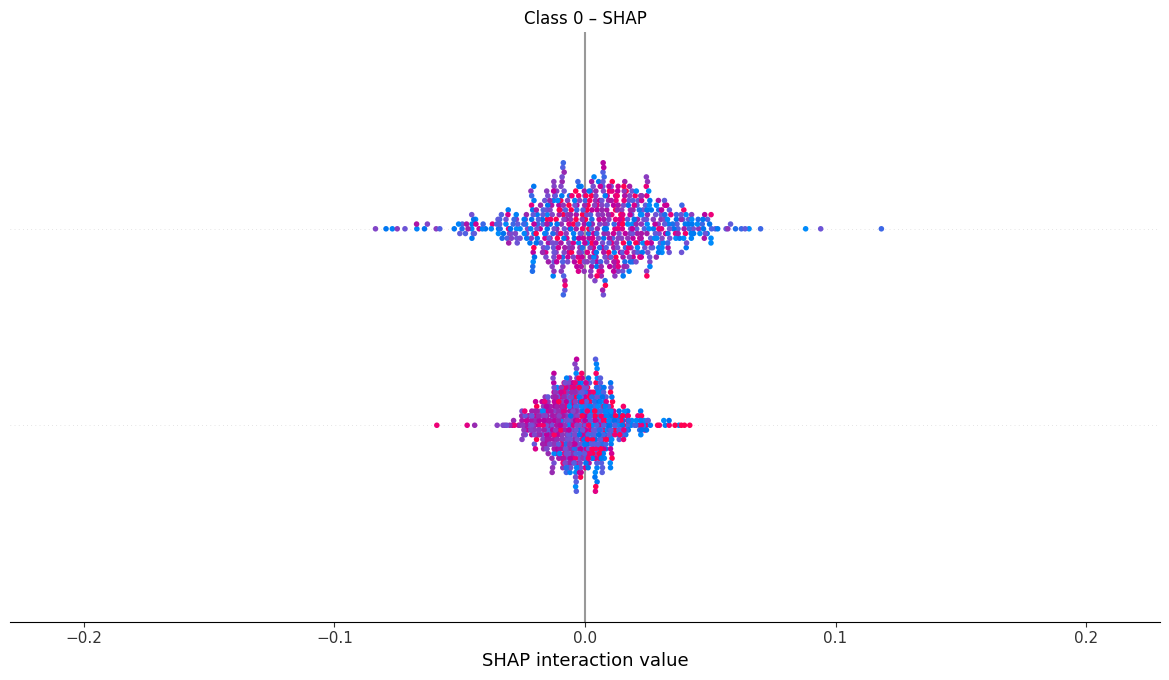

In [ ]:


plt.figure(figsize=(10,4))

# --- Class 0 (low-quality) ---
plt.subplot(1,2,1)
shap.summary_plot(
    shap_vals[class_0_idx],                
    X_test_trans[class_0_idx],              
    feature_names=feature_names,
    show=False
)
plt.title("Class 0 – SHAP")



<Figure size 1000x400 with 0 Axes>

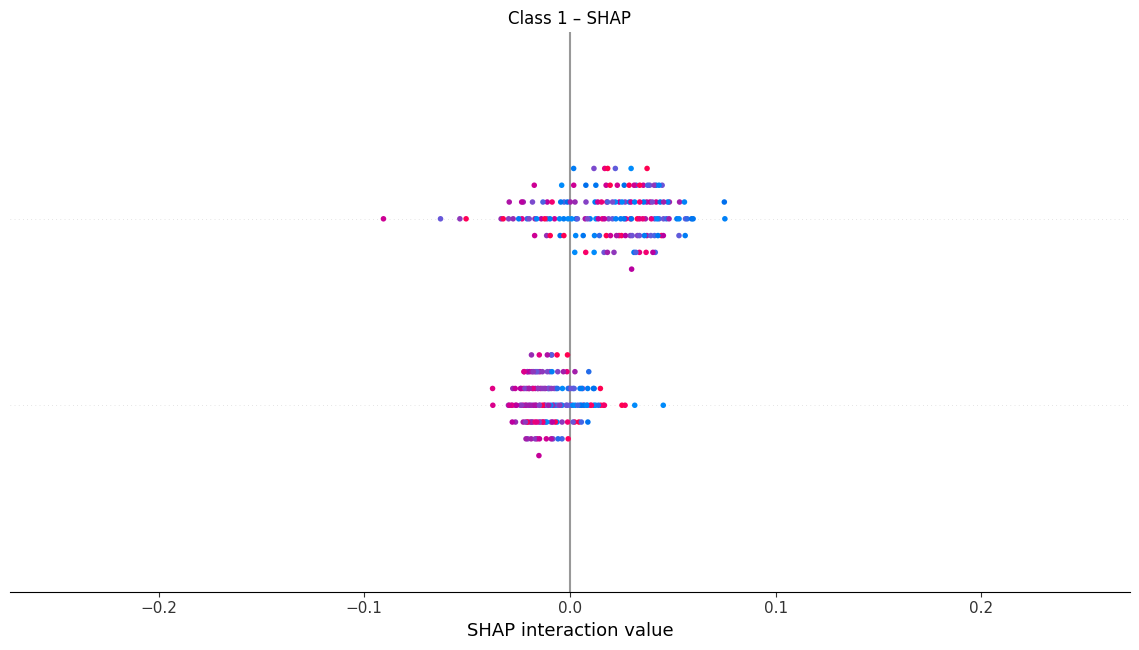

In [58]:
plt.figure(figsize=(10,4))

# --- Class 1 (high-quality) ---
plt.subplot(1,2,2)
shap.summary_plot(
    shap_vals[class_1_idx],
    X_test_trans[class_1_idx],
    feature_names=feature_names,
    show=False
)
plt.title("Class 1 – SHAP")

plt.tight_layout(); plt.show()

In [ ]:
import shap
import matplotlib.pyplot as plt
import os
import scipy.sparse as sp
import numpy as np
import pandas as pd


print("Analyzing SHAP values shape:")
if hasattr(shap_vals, 'values'):
    shap_values = shap_vals.values
else:
    shap_values = shap_vals

print(f"SHAP values shape: {shap_values.shape}")
print(f"X_test_trans shape: {X_test_trans.shape}")


X_features = X_test_trans.toarray() if sp.issparse(X_test_trans) else X_test_trans
feature_names = best_model.named_steps["preprocess"].get_feature_names_out()


X_df = pd.DataFrame(X_features, columns=feature_names)


if shap_values.ndim == 3:  
    print(f"Multi-class SHAP values detected with {shap_values.shape[2]} classes")

    
    if shap_values.shape[2] == 2:
        print("Using positive class (index 1) SHAP values")
        shap_matrix = shap_values[:, :, 1]  
    else:
        
        print(f"Using sum of absolute SHAP values across all {shap_values.shape[2]} classes")
        shap_matrix = np.abs(shap_values).sum(axis=2)
elif shap_values.ndim == 2:  
    print("Binary/regression SHAP values detected")
    shap_matrix = shap_values
else:
    raise ValueError(f"Unexpected SHAP values shape: {shap_values.shape}")

print(f"Processed SHAP matrix shape: {shap_matrix.shape}")
print(f"X_df shape: {X_df.shape}")


os.makedirs("shap_feature_plots", exist_ok=True)



plt.figure(figsize=(12, 10))
shap.summary_plot(shap_matrix, X_df, show=False, max_display=20)
plt.title("SHAP Feature Importance Summary", fontsize=16)
plt.tight_layout()
plt.savefig("shap_feature_plots/00_summary_plot.png", dpi=150, bbox_inches='tight')
plt.close()
print("✓ Generated summary plot")


plt.figure(figsize=(12, 10))
shap.summary_plot(shap_matrix, X_df, plot_type='bar', show=False, max_display=20)
plt.title("SHAP Feature Importance Ranking", fontsize=16)
plt.tight_layout()
plt.savefig("shap_feature_plots/01_importance_ranking.png", dpi=150, bbox_inches='tight')
plt.close()




for i, name in enumerate(feature_names):
    
    fig, ax = plt.subplots(figsize=(10, 8))

    
    feature_importance = np.abs(shap_matrix[:, i]).mean()

    x = X_df[name].values
    y = shap_matrix[:, i]

    
    if name.startswith('cat__'):
        x = x + np.random.normal(0, 0.05, size=len(x))

    
    ax.scatter(x, y, color='blue', alpha=0.7, s=50)

    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(sorted(x), p(sorted(x)), 'r--', linewidth=2)

    
    ax.set_xlabel(name, fontsize=14)
    ax.set_ylabel(f"SHAP value", fontsize=14)

   
    all_importances = np.array([np.abs(shap_matrix[:, j]).mean() for j in range(shap_matrix.shape[1])])
    percentile = 100 * (1 - (np.searchsorted(np.sort(all_importances), feature_importance) / len(all_importances)))
    ax.set_title(f"SHAP Value vs {name}\nImportance: {feature_importance:.4f} (Top {percentile:.1f}%)", fontsize=16)

    
    ax.grid(True, linestyle='--', alpha=0.6)

    
    plt.tight_layout()
    file_path = f"shap_feature_plots/{i:02d}_{name.replace('/', '_')}.png"
    plt.savefig(file_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    



print(" most important features:")

feature_importances = [(name, np.abs(shap_matrix[:, i]).mean()) for i, name in enumerate(feature_names)]
feature_importances.sort(key=lambda x: x[1], reverse=True)
for i, (name, importance) in enumerate(feature_importances[:5]):
    print(f"{i+1}. {name}: {importance:.4f}")

Analyzing SHAP values shape...
SHAP values shape: (793, 18, 2)
X_test_trans shape: (793, 18)
Multi-class SHAP values detected with 2 classes
Using positive class (index 1) SHAP values
Processed SHAP matrix shape: (793, 18)
X_df shape: (793, 18)

Generating summary plot for all features...
✓ Generated summary plot
✓ Generated feature importance ranking plot

Generating simple dependence plots for each feature...
✓ Generated plot for feature: num__fixed acidity
✓ Generated plot for feature: num__volatile acidity
✓ Generated plot for feature: num__citric acid
✓ Generated plot for feature: num__residual sugar
✓ Generated plot for feature: num__chlorides
✓ Generated plot for feature: num__free sulfur dioxide
✓ Generated plot for feature: num__total sulfur dioxide
✓ Generated plot for feature: num__density
✓ Generated plot for feature: num__pH
✓ Generated plot for feature: num__sulphates
✓ Generated plot for feature: num__alcohol
✓ Generated plot for feature: num__free_total_sulf_ratio
✓ Gen